In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [69]:
# CONSTANTS!!!

# STEP 1 - Load and visualize data
dataInputPath = '/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/1-Original Data/NFBS Sample/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = '/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/2-2D Slices/Sample/'
imageSliceOutput = os.path.join(dataOutputPath, 'image/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')


In [70]:
# STEP 2 - Image normalization
HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 1300
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

In [71]:
# STEP 3 - Slicing and saving
SLICE_X = True
SLICE_Y = True
SLICE_Z = True

In [72]:
SLICE_DECIMATE_IDENTIFIER = 3

In [73]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'sub-A00028185_ses-NFB3_T1w.nii.gz')
img = nib.load(imgPath).get_fdata()
print ("Min pixel intensity: ", np.min(img))
print ("Max pixel intensity: ", np.max(img))
print ("Image shape: ",img.shape)
print ("Image Type: ", type(img))

Min pixel intensity:  0.0
Max pixel intensity:  1205.0
Image shape:  (256, 256, 192)
Image Type:  <class 'numpy.ndarray'>


In [74]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, 'sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz')
mask = nib.load(maskPath).get_fdata()


print ("Min pixel intensity: ", np.min(mask))
print ("Max pixel intensity: ", np.max(mask))
print ("Image shape: ",mask.shape)
print ("Image Type: ", type(mask))


Min pixel intensity:  0.0
Max pixel intensity:  1.0
Image shape:  (256, 256, 192)
Image Type:  <class 'numpy.ndarray'>


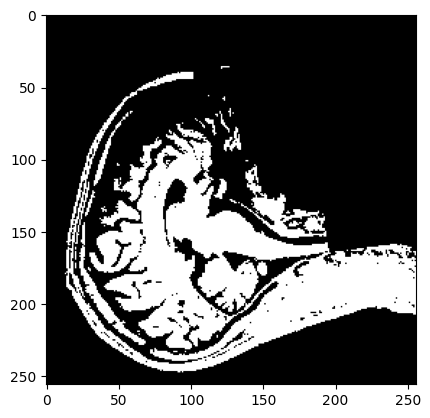

In [75]:
# Show image slice
imgSlice = mask[:,:,100]
plt.imshow(imgSlice, cmap='gray')
plt.show()

Normalizing the Image

In [76]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 0.926923076923077, (256, 256, 192), numpy.ndarray)

In [77]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [82]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [79]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing Coronal: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_Coronal', path)

    if SLICE_Y:
        cnt += dimy
        print('Slicing Axial: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_Axial', path)

    if SLICE_Z:
        cnt += dimz
        print('Slicing Sagittal: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_Sagittal', path)
    return cnt

In [80]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'MRI'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/1-Original Data/NFBS Sample/img/sub-A00028185_ses-NFB3_T1w.nii.gz (256, 256, 192) 704 0.0 0.926923076923077
256 256 192
Slicing Coronal: 
Slicing Axial: 
Slicing Sagittal: 
[+] Slice saved: /content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/2-2D Slices/Sample/image/MRI0-slice191_Sagittal.png
/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/1-Original Data/NFBS Sample/img/sub-A00028185_ses-NFB3_T1w.nii.gz, 704 slices created 



In [81]:
# Read and process mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    mask = readImageVolume(filename, False)
    print(filename, mask.shape, np.sum(mask.shape), np.min(mask), np.max(mask))
    numOfSlices = sliceAndSaveVolumeImage(mask, 'MRI'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/1-Original Data/NFBS Sample/mask/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz (256, 256, 192) 704 0.0 1.0
256 256 192
Slicing Coronal: 
Slicing Axial: 
Slicing Sagittal: 
[+] Slice saved: /content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/2-2D Slices/Sample/mask/MRI0-slice191_Sagittal.png
/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/1-Original Data/NFBS Sample/mask/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz, 704 slices created 

